# Exploración del conjunto de datos
En este notebook exploraremos los datos para poder tomar una decisión sobre el diseño de la solución. En cada sección encontrarás preguntas con la intención de motivar una reflexión sobre su diseño. Mientras que no necesitan ser respondidas explícitamente, les invito a que las utilicen como guía al momento de justificar sus decisiones de diseño y presentar sus resultados.

## Datos de entrenamiento
En el conjunto de datos tenemos información sobre las *compras* realizadas en una tienda de ropa en linea. En la siguiente celda podemos ver las columnas o atributos que tenemos a nuestra disposición.
- ¿Tenemos valores faltantes o todas las columans tienen la información completa?
- ¿Qué tipos de columnas tenemos y cómo podemos procesarlas?

In [4]:
import pandas as pd
import os
train_file = "../../datasets/customer_purchases/customer_purchases_train.csv"
train_file = os.path.abspath(train_file)
train_df = pd.read_csv(train_file)

train_df.info()
train_df.columns

# Revisión de datos faltantes
missing_values = train_df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)
# Tipos de columnas
print("Tiposde columnas: \n", train_df.dtypes)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7289 entries, 0 to 7288
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_id             7289 non-null   int64  
 1   customer_id             7289 non-null   object 
 2   customer_date_of_birth  7289 non-null   object 
 3   customer_gender         5738 non-null   object 
 4   customer_signup_date    7289 non-null   object 
 5   item_id                 7289 non-null   object 
 6   item_title              7289 non-null   object 
 7   item_category           7289 non-null   object 
 8   item_price              7289 non-null   float64
 9   item_img_filename       7289 non-null   object 
 10  item_avg_rating         7244 non-null   float64
 11  item_num_ratings        7289 non-null   int64  
 12  item_release_date       7289 non-null   object 
 13  purchase_timestamp      7289 non-null   object 
 14  customer_item_views     7289 non-null   

### Como procesar cada tipo de Columna: ###
Si es de tipo object...
Si es entero...
Si es float...
Si es fecha...

## Prueba
Recuerda que en prueba queremos saber si un cliente existente comprará un produco *no existente*. En el conjunto anterior tenemos columnas que solo tendrán información si se ha generado una compra, ¿Que columnas son estas? 
- purchase_timestamp       
- purchase_item_rating    
- customer_item_views     
- purchase_device          
- item_avg_rating         
- item_num_ratings        

¿Que valores podríamos esperar de las mismas para productos que no han salido a la venta? ¿Tiene sentido usarlas en entrenamiento tal cual? No porque introducen leakage: el modelo aprendería de información que no estará disponible en el momento de la predicción.

¿Podemos extraer información valiosa de las mismas? Si, aunque no se ulticen directamente se pueden crear atributos o features: 
- De purchase_timestamp: frecuencia de compra por cliente, hora preferida, día de la semana.
- De purchase_item_rating: promedio de calificación por producto o categoría.
- De purchase_device: dispositivos más usados por cliente.
- De customer_item_views: interés previo por categoría o tipo de producto.
- De item_avg_rating y item_num_ratings: popularidad y reputación del producto.


In [11]:
import pandas as pd
import os
test_file = "../../datasets/customer_purchases/customer_purchases_test.csv"
test_file = os.path.abspath(test_file)
test_df = pd.read_csv(test_file)

test_df.info()
test_df.columns




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_id             978 non-null    int64  
 1   customer_id             978 non-null    object 
 2   customer_date_of_birth  978 non-null    object 
 3   customer_gender         800 non-null    object 
 4   customer_signup_date    978 non-null    object 
 5   item_id                 978 non-null    object 
 6   item_title              978 non-null    object 
 7   item_category           978 non-null    object 
 8   item_price              978 non-null    float64
 9   item_img_filename       978 non-null    object 
 10  item_avg_rating         0 non-null      float64
 11  item_num_ratings        0 non-null      float64
 12  item_release_date       978 non-null    object 
 13  purchase_timestamp      0 non-null      float64
 14  customer_item_views     0 non-null      fl

Index(['purchase_id', 'customer_id', 'customer_date_of_birth',
       'customer_gender', 'customer_signup_date', 'item_id', 'item_title',
       'item_category', 'item_price', 'item_img_filename', 'item_avg_rating',
       'item_num_ratings', 'item_release_date', 'purchase_timestamp',
       'customer_item_views', 'purchase_item_rating', 'purchase_device'],
      dtype='object')

# Visualizar los datos por etiqueta

Visualiza las etiquetas del conjunto de datos de entrenamiento

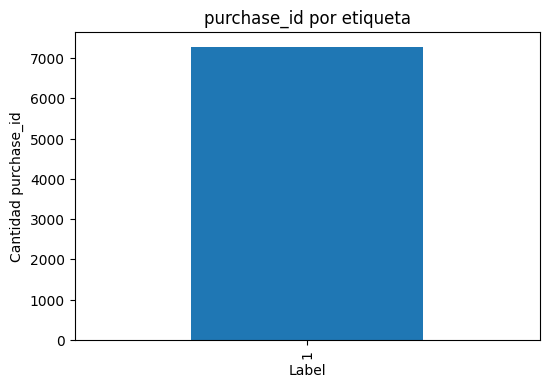

In [12]:
import matplotlib.pyplot as plt

train_df["label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="Cantidad purchase_id",
    title="purchase_id por etiqueta",
    figsize=(6,4)
)
plt.show()

¿Notas algo extraño?  ¿Podemos entrenar un algoritmo de ML en este dataset tal cual se nos presenta?
¿Qué problemas podríamos encontrarnos?

## Visualizar estadisticas por producto y por cliente

En el dataset solo tenemos información de las *compras*, es decir cada que se repite un `customer_id`, podemos saber cuantas compras ha hecho ese cliente. De la misma manera, contar cuantas veces se repite un `item_id` nos dice cuantas veces se ha comprado ese producto. Utiliza pandas para ver si existen clientes que compran que mayor frecuencia que otros, o productos que se compran mas que otros. Responde:
- ¿Consideras que los datos se encuentran balanceados dada la información anterior?
- ¿Qué estrategías podrian ser útiles al momento de generar negativos?

### Datos por usuario

In [37]:
# Conteo de compras por cliente
by_customer = train_df["customer_id"].value_counts()
print(by_customer.describe())

print("Clientes únicos:", train_df["customer_id"].nunique())
print("Productos únicos:", train_df["item_id"].nunique())


count    500.000000
mean      14.578000
std        5.273665
min        4.000000
25%       11.000000
50%       14.000000
75%       18.000000
max       34.000000
Name: count, dtype: float64
Clientes únicos: 500
Productos únicos: 384


¿Cómo podemos interpretar la información anterior?
- Hay clientes muy activos (hasta 34 compras) y otros menos (solo 4).
- La distribución está moderadamente dispersa (std = 5.27), lo que indica que no todos los clientes se comportan igual.
- Esto sugiere que el dataset no está balanceado por cliente: algunos tienen más influencia en el modelo que otros


Visualicemos ahora en una gráfica

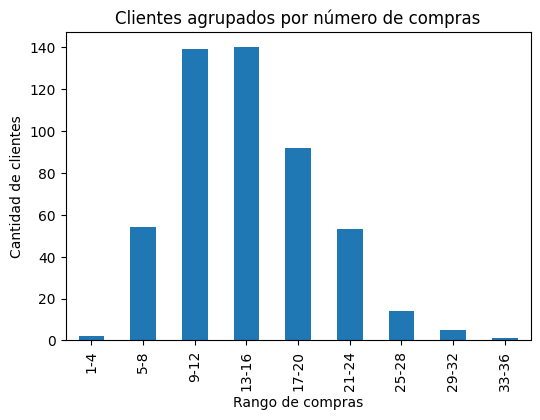

In [38]:
max_val = by_customer.max()
nbuckets = 7
increment = max_val // nbuckets

bins = []
labels = []
bins = list(range(0, max_val + increment, increment))
labels = [f"{bins[i]+1}-{bins[i+1]}" for i in range(len(bins)-1)]


customer_by_purchase = train_df['customer_id'].value_counts()
customer_buckets = pd.cut(customer_by_purchase, bins=bins, labels=labels)
bucket_counts = customer_buckets.value_counts().sort_index()

bucket_counts.plot(kind="bar", figsize=(6,4))
plt.title("Clientes agrupados por número de compras")
plt.xlabel("Rango de compras")
plt.ylabel("Cantidad de clientes")
plt.show()

### Datos por item

In [39]:
# Conteo de compras por producto
by_item = train_df["item_id"].value_counts()
print(by_item.describe())


count    384.000000
mean      18.981771
std        4.302793
min        9.000000
25%       16.000000
50%       19.000000
75%       22.000000
max       33.000000
Name: count, dtype: float64


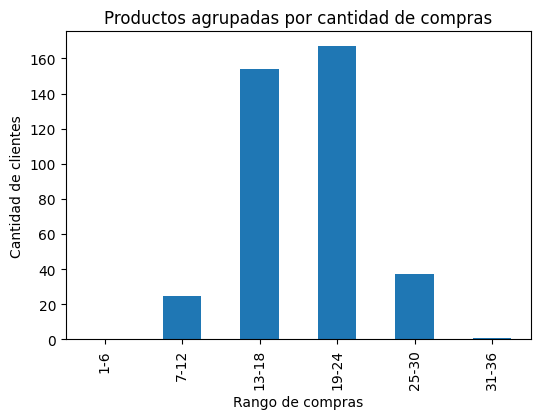

In [40]:
max_val = by_item.max()
nbuckets = 5
increment = max_val // nbuckets

bins = []
labels = []
bins = list(range(0, max_val + increment, increment))
labels = [f"{bins[i]+1}-{bins[i+1]}" for i in range(len(bins)-1)]


items_by_purchase = train_df['item_id'].value_counts()
item_buckets = pd.cut(items_by_purchase, bins=bins, labels=labels)
item_counts = item_buckets.value_counts().sort_index()

item_counts.plot(kind="bar", figsize=(6,4))
plt.title("Productos agrupadas por cantidad de compras")
plt.xlabel("Rango de compras")
plt.ylabel("Cantidad de clientes")
plt.show()

# Generación ejemplos negativos

Como pudiste notar solo tenemos información de compras. Si se deseara realizar un algoritmo de clasificación para productos nuevos, este fallaría al ser entrneado en el dataset original ya que no tendría información de ejemplos negativos. Por lo anterior, este tipo de problemas comunmente se modela como sistemas de recomendación. 

Otra manera de resolverlo, es generar ejemplos negativos dada la información en el conjunto, por ejemplo sabemos el inventario completo (los `item_id` únicos) y sus atributos, asi como el conjunto completo de clientes (`customer_id` únicos) y para cada cliente sabemos los productos que han comprado, *pero tambien sabemos los que no compraron* si al conjunto de productos completo, le restamos el conjunto de productos que si compró. Esto nos da una señal de ejemplos negativos que podemos usar para clasificación.

Dicho esto tienes 2 opciones:
1. Investigar sistemas de recomendación tradicionales [(collaborative filtering, content-based filtering etc)](https://www.geeksforgeeks.org/machine-learning/content-based-vs-collaborative-filtering-difference/)
2. Modelaro como un sistema de clasificación y generar tus propios ejemplos negativos

Son libres de elegir la decisión que prefieran.

En el caso de clasificación tenemos que considerar lo siguiente: Para muchos clientes, el conjunto de items no comprados será mucho mayor que el de items comprados. 
- ¿Qué problemas puedo tener si elijo como negativos todos los no comprados para todos los clientes?
- ¿Pueden pensar en diferentes estrategias para generar los negativos?

Pueden utilizar el archivo [negative_generation.py](./negative_generation.py) para implementar diferentes estrategias de generación de negativos. 

In [21]:
from ml_clases.proyectos.P01_customer_purchases.negative_generation import gen_all_negatives, gen_random_negatives

train_df_neg = gen_random_negatives(train_df,n_per_positive=1)

train_df_full = pd.concat((train_df, train_df_neg))
# Shuffle para que cuando hagamos el split tengamos de ambos muestras
train_df_full = train_df_full.sample(frac=1) # 100%

train_df_full["label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="Cantidad purchase_id",
    title="purchase_id por etiqueta",
    figsize=(6,4)
)
plt.show()

ModuleNotFoundError: No module named 'ml_clases'

- ¿Que podemos observar cuando generamos todos los negativos?
- ¿Se les ocurre otra manera de elegirlos?

## Entregables: Análisis exploratorio
Dentro de sus entregables de analisis, intenten responder a las preguntas:
- ¿Existen valores faltantes (i.e. NaN / None)? ¿Como proponen manejarlos?
    Sí, se detectaron valores faltantes en columnas como item_avg_rating y especialmente en purchase_item_rating, que tiene muchos nulos porque solo se registra cuando el cliente califica el producto.
Propuesta de manejo:
- Para columnas con pocos nulos como item_avg_rating: imputar con la media por categoría o producto.
- Para columnas con muchos nulos como purchase_item_rating: no usarlas directamente, pero sí derivar atributos agregados (por ejemplo, promedio de rating por producto).
- Eliminar columnas que no aporten valor o estén completamente vacías en el conjunto de prueba.

- ¿Que atributos pueden ser predictores útiles?
    - item_category: puede reflejar preferencias del cliente.
    - item_price: útil para segmentar productos por rango económico.
    - customer_item_views: indica interés previo.

    - Atributos derivados como:
    - Frecuencia de compra por cliente.
    - Popularidad del producto.
    - Promedio de gasto por cliente.
    - Historial de categorías compradas.

- ¿Tenemos etiquetas balanceadas? ¿Cómo van a manejarlas? No estan balanceadas, vamos a generar negativos.

- ¿Que cantidad de productos existententes vs. nuevos tenemos?

- ¿Cuantos clientes tenemos?
 El conjunto de entrenamiento contiene 500 clientes únicos
 
- ¿Que tipos de datos tenemos y como podemos procesarlos?
- ¿Existen correlaciones fuertes entre variables dependientes?
- ¿Que correlaciones pueden ver entre las variables dependientes y la independiente?

### Bonus:
Se otorgarán puntos extra a análisis exploratorios excepcionales que integren diferentes métodos de ML visualizaciones y reconocimientos de patrones más complejos que vayan mas allá de lo propuesto/observado en este notebook.

### Recomendaciones generales
- Les recomiendo explorar la libreria de [seaborn](https://seaborn.pydata.org/) y las diferentes opciones de visualización que tienen.
- Los resultados de este problema dependen en gran medida de los atributos derivados y manejo de datos por lo que les recomiento invertir la mayoría de su tiempo a explorar entrenamiento con diferentes conjuntos de atributos.

### Valores Faltantes ###

In [27]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


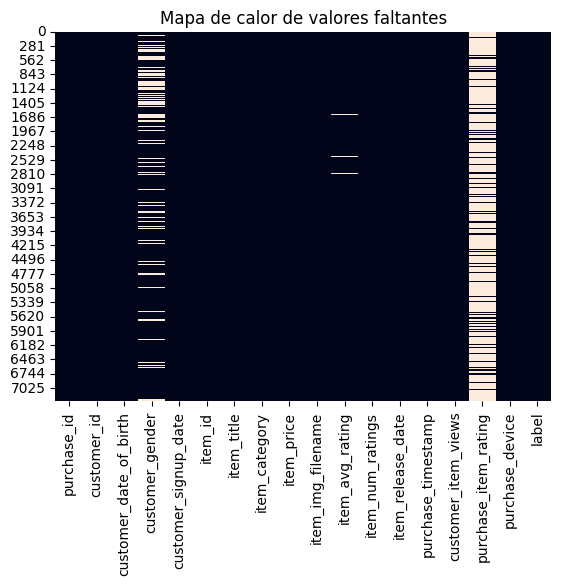

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Mapa de calor de valores faltantes")
plt.show()


### Distribución de item_price

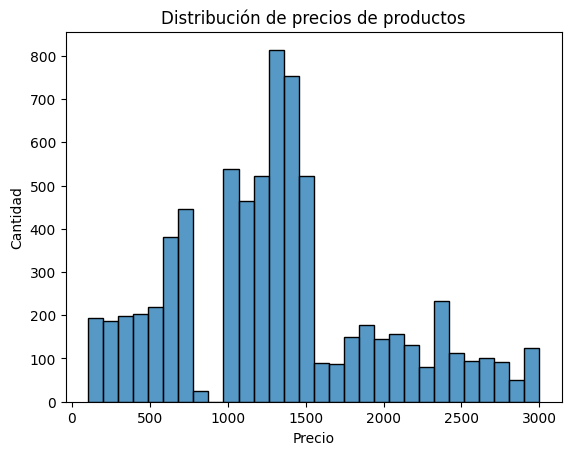

In [29]:
sns.histplot(train_df["item_price"], bins=30)
plt.title("Distribución de precios de productos")
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.show()

### Relación entre vistas y compra ###

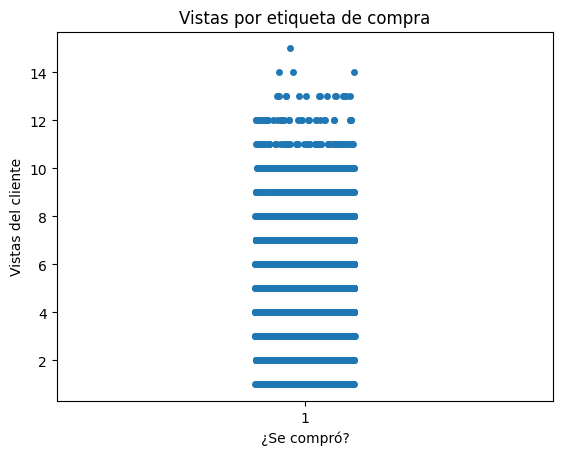

In [36]:
sns.stripplot(x="label", y="customer_item_views", data=train_df, jitter=True)
plt.title("Vistas por etiqueta de compra")
plt.xlabel("¿Se compró?")
plt.ylabel("Vistas del cliente")
plt.show()



# Exploración del conjunto de datos
En este notebook exploraremos los datos para poder tomar una decisión sobre el diseño de la solución. En cada sección encontrarás preguntas con la intención de motivar una reflexión sobre su diseño. Mientras que no necesitan ser respondidas explícitamente, les invito a que las utilicen como guía al momento de justificar sus decisiones de diseño y presentar sus resultados.

## Datos de entrenamiento
En el conjunto de datos tenemos información sobre las *compras* realizadas en una tienda de ropa en linea. En la siguiente celda podemos ver las columnas o atributos que tenemos a nuestra disposición.
- ¿Tenemos valores faltantes o todas las columans tienen la información completa?
- ¿Qué tipos de columnas tenemos y cómo podemos procesarlas?

In [ ]:
import pandas as pd
import os
train_file = "../../datasets/customer_purchases/customer_purchases_train.csv"
train_file = os.path.abspath(train_file)
train_df = pd.read_csv(train_file)

train_df.info()
train_df.columns

# Revisión de datos faltantes
missing_values = train_df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)
# Tipos de columnas
print("Tiposde columnas: \n", train_df.dtypes)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7289 entries, 0 to 7288
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_id             7289 non-null   int64  
 1   customer_id             7289 non-null   object 
 2   customer_date_of_birth  7289 non-null   object 
 3   customer_gender         5738 non-null   object 
 4   customer_signup_date    7289 non-null   object 
 5   item_id                 7289 non-null   object 
 6   item_title              7289 non-null   object 
 7   item_category           7289 non-null   object 
 8   item_price              7289 non-null   float64
 9   item_img_filename       7289 non-null   object 
 10  item_avg_rating         7244 non-null   float64
 11  item_num_ratings        7289 non-null   int64  
 12  item_release_date       7289 non-null   object 
 13  purchase_timestamp      7289 non-null   object 
 14  customer_item_views     7289 non-null   

## Prueba
Recuerda que en prueba queremos saber si un cliente existente comprará un produco *no existente*. En el conjunto anterior tenemos columnas que solo tendrán información si se ha generado una compra, ¿Que columnas son estas? 
- purchase_timestamp       
- purchase_item_rating    
- customer_item_views     
- purchase_device          
- item_avg_rating         
- item_num_ratings        

¿Que valores podríamos esperar de las mismas para productos que no han salido a la venta? ¿Tiene sentido usarlas en entrenamiento tal cual? No porque introducen leakage: el modelo aprendería de información que no estará disponible en el momento de la predicción.

¿Podemos extraer información valiosa de las mismas? Si, aunque no se ulticen directamente se pueden crear atributos o features: 
- De purchase_timestamp: frecuencia de compra por cliente, hora preferida, día de la semana.
- De purchase_item_rating: promedio de calificación por producto o categoría.
- De purchase_device: dispositivos más usados por cliente.
- De customer_item_views: interés previo por categoría o tipo de producto.
- De item_avg_rating y item_num_ratings: popularidad y reputación del producto.


In [ ]:
import pandas as pd
import os
test_file = "../../datasets/customer_purchases/customer_purchases_test.csv"
test_file = os.path.abspath(test_file)
test_df = pd.read_csv(test_file)

test_df.info()
test_df.columns




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_id             978 non-null    int64  
 1   customer_id             978 non-null    object 
 2   customer_date_of_birth  978 non-null    object 
 3   customer_gender         800 non-null    object 
 4   customer_signup_date    978 non-null    object 
 5   item_id                 978 non-null    object 
 6   item_title              978 non-null    object 
 7   item_category           978 non-null    object 
 8   item_price              978 non-null    float64
 9   item_img_filename       978 non-null    object 
 10  item_avg_rating         0 non-null      float64
 11  item_num_ratings        0 non-null      float64
 12  item_release_date       978 non-null    object 
 13  purchase_timestamp      0 non-null      float64
 14  customer_item_views     0 non-null      fl

Index(['purchase_id', 'customer_id', 'customer_date_of_birth',
       'customer_gender', 'customer_signup_date', 'item_id', 'item_title',
       'item_category', 'item_price', 'item_img_filename', 'item_avg_rating',
       'item_num_ratings', 'item_release_date', 'purchase_timestamp',
       'customer_item_views', 'purchase_item_rating', 'purchase_device'],
      dtype='object')

# Visualizar los datos por etiqueta

Visualiza las etiquetas del conjunto de datos de entrenamiento

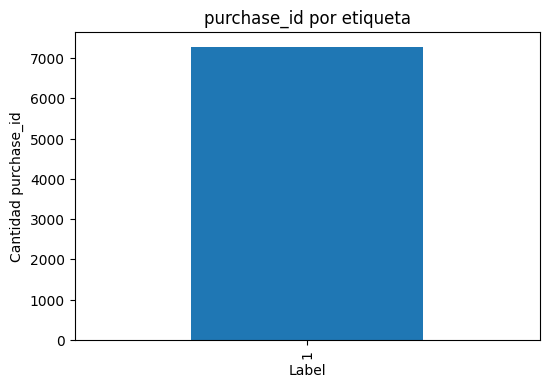

In [ ]:
import matplotlib.pyplot as plt

train_df["label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="Cantidad purchase_id",
    title="purchase_id por etiqueta",
    figsize=(6,4)
)
plt.show()

¿Notas algo extraño?  ¿Podemos entrenar un algoritmo de ML en este dataset tal cual se nos presenta?
¿Qué problemas podríamos encontrarnos?

## Visualizar estadisticas por producto y por cliente

En el dataset solo tenemos información de las *compras*, es decir cada que se repite un `customer_id`, podemos saber cuantas compras ha hecho ese cliente. De la misma manera, contar cuantas veces se repite un `item_id` nos dice cuantas veces se ha comprado ese producto. Utiliza pandas para ver si existen clientes que compran que mayor frecuencia que otros, o productos que se compran mas que otros. Responde:
- ¿Consideras que los datos se encuentran balanceados dada la información anterior?
- ¿Qué estrategías podrian ser útiles al momento de generar negativos?

### Datos por usuario

In [ ]:
# Conteo de compras por cliente
by_customer = train_df["customer_id"].value_counts()
print(by_customer.describe())

print("Clientes únicos:", train_df["customer_id"].nunique())
print("Productos únicos:", train_df["item_id"].nunique())


count    500.000000
mean      14.578000
std        5.273665
min        4.000000
25%       11.000000
50%       14.000000
75%       18.000000
max       34.000000
Name: count, dtype: float64
Clientes únicos: 500
Productos únicos: 384


¿Cómo podemos interpretar la información anterior?
- Hay clientes muy activos (hasta 34 compras) y otros menos (solo 4).
- La distribución está moderadamente dispersa (std = 5.27), lo que indica que no todos los clientes se comportan igual.
- Esto sugiere que el dataset no está balanceado por cliente: algunos tienen más influencia en el modelo que otros


Visualicemos ahora en una gráfica

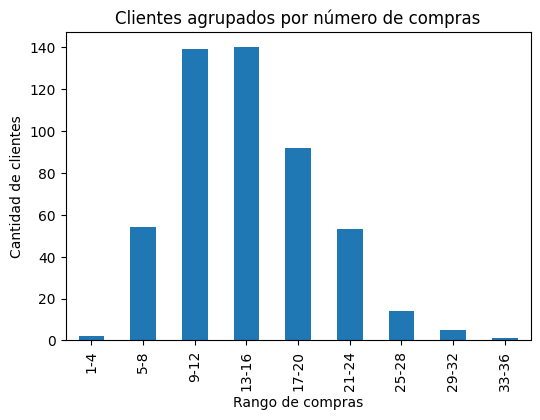

In [ ]:
max_val = by_customer.max()
nbuckets = 7
increment = max_val // nbuckets

bins = []
labels = []
bins = list(range(0, max_val + increment, increment))
labels = [f"{bins[i]+1}-{bins[i+1]}" for i in range(len(bins)-1)]


customer_by_purchase = train_df['customer_id'].value_counts()
customer_buckets = pd.cut(customer_by_purchase, bins=bins, labels=labels)
bucket_counts = customer_buckets.value_counts().sort_index()

bucket_counts.plot(kind="bar", figsize=(6,4))
plt.title("Clientes agrupados por número de compras")
plt.xlabel("Rango de compras")
plt.ylabel("Cantidad de clientes")
plt.show()

### Datos por item

In [ ]:
# Conteo de compras por producto
by_item = train_df["item_id"].value_counts()
print(by_item.describe())


count    384.000000
mean      18.981771
std        4.302793
min        9.000000
25%       16.000000
50%       19.000000
75%       22.000000
max       33.000000
Name: count, dtype: float64


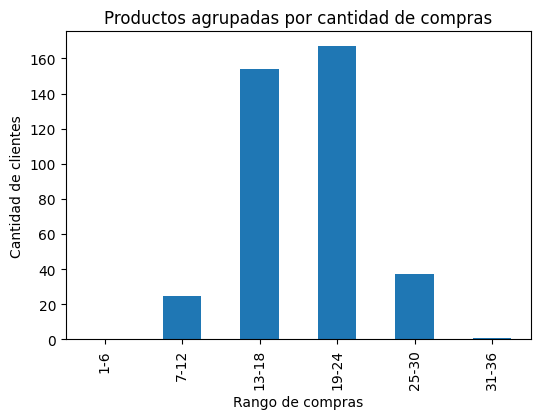

In [ ]:
max_val = by_item.max()
nbuckets = 5
increment = max_val // nbuckets

bins = []
labels = []
bins = list(range(0, max_val + increment, increment))
labels = [f"{bins[i]+1}-{bins[i+1]}" for i in range(len(bins)-1)]


items_by_purchase = train_df['item_id'].value_counts()
item_buckets = pd.cut(items_by_purchase, bins=bins, labels=labels)
item_counts = item_buckets.value_counts().sort_index()

item_counts.plot(kind="bar", figsize=(6,4))
plt.title("Productos agrupadas por cantidad de compras")
plt.xlabel("Rango de compras")
plt.ylabel("Cantidad de clientes")
plt.show()

# Generación ejemplos negativos

Como pudiste notar solo tenemos información de compras. Si se deseara realizar un algoritmo de clasificación para productos nuevos, este fallaría al ser entrneado en el dataset original ya que no tendría información de ejemplos negativos. Por lo anterior, este tipo de problemas comunmente se modela como sistemas de recomendación. 

Otra manera de resolverlo, es generar ejemplos negativos dada la información en el conjunto, por ejemplo sabemos el inventario completo (los `item_id` únicos) y sus atributos, asi como el conjunto completo de clientes (`customer_id` únicos) y para cada cliente sabemos los productos que han comprado, *pero tambien sabemos los que no compraron* si al conjunto de productos completo, le restamos el conjunto de productos que si compró. Esto nos da una señal de ejemplos negativos que podemos usar para clasificación.

Dicho esto tienes 2 opciones:
1. Investigar sistemas de recomendación tradicionales [(collaborative filtering, content-based filtering etc)](https://www.geeksforgeeks.org/machine-learning/content-based-vs-collaborative-filtering-difference/)
2. Modelaro como un sistema de clasificación y generar tus propios ejemplos negativos

Son libres de elegir la decisión que prefieran.

En el caso de clasificación tenemos que considerar lo siguiente: Para muchos clientes, el conjunto de items no comprados será mucho mayor que el de items comprados. 
- ¿Qué problemas puedo tener si elijo como negativos todos los no comprados para todos los clientes?
- ¿Pueden pensar en diferentes estrategias para generar los negativos?

Pueden utilizar el archivo [negative_generation.py](./negative_generation.py) para implementar diferentes estrategias de generación de negativos. 

In [ ]:
from ml_clases.proyectos.P01_customer_purchases.negative_generation import gen_all_negatives, gen_random_negatives

train_df_neg = gen_random_negatives(train_df,n_per_positive=1)

train_df_full = pd.concat((train_df, train_df_neg))
# Shuffle para que cuando hagamos el split tengamos de ambos muestras
train_df_full = train_df_full.sample(frac=1) # 100%

train_df_full["label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="Cantidad purchase_id",
    title="purchase_id por etiqueta",
    figsize=(6,4)
)
plt.show()

ModuleNotFoundError: No module named 'ml_clases'

- ¿Que podemos observar cuando generamos todos los negativos?
- ¿Se les ocurre otra manera de elegirlos?

In [ ]:
import seaborn as sns
sns.pairplot(train_df_full)

ModuleNotFoundError: No module named 'seaborn'

## Entregables: Análisis exploratorio
Dentro de sus entregables de analisis, intenten responder a las preguntas:
- ¿Existen valores faltantes (i.e. NaN / None)? ¿Como proponen manejarlos?
    Sí, se detectaron valores faltantes en columnas como item_avg_rating y especialmente en purchase_item_rating, que tiene muchos nulos porque solo se registra cuando el cliente califica el producto.
Propuesta de manejo:
- Para columnas con pocos nulos como item_avg_rating: imputar con la media por categoría o producto.
- Para columnas con muchos nulos como purchase_item_rating: no usarlas directamente, pero sí derivar atributos agregados (por ejemplo, promedio de rating por producto).
- Eliminar columnas que no aporten valor o estén completamente vacías en el conjunto de prueba.

- ¿Que atributos pueden ser predictores útiles?
    - item_category: puede reflejar preferencias del cliente.
    - item_price: útil para segmentar productos por rango económico.
    - customer_item_views: indica interés previo.

    - Atributos derivados como:
    - Frecuencia de compra por cliente.
    - Popularidad del producto.
    - Promedio de gasto por cliente.
    - Historial de categorías compradas.

- ¿Tenemos etiquetas balanceadas? ¿Cómo van a manejarlas? No estan balanceadas, vamos a generar negativos.

- ¿Que cantidad de productos existententes vs. nuevos tenemos?

- ¿Cuantos clientes tenemos?
 El conjunto de entrenamiento contiene 500 clientes únicos
 
- ¿Que tipos de datos tenemos y como podemos procesarlos?
- ¿Existen correlaciones fuertes entre variables dependientes?
- ¿Que correlaciones pueden ver entre las variables dependientes y la independiente?

### Bonus:
Se otorgarán puntos extra a análisis exploratorios excepcionales que integren diferentes métodos de ML visualizaciones y reconocimientos de patrones más complejos que vayan mas allá de lo propuesto/observado en este notebook.

### Recomendaciones generales
- Les recomiendo explorar la libreria de [seaborn](https://seaborn.pydata.org/) y las diferentes opciones de visualización que tienen.
- Los resultados de este problema dependen en gran medida de los atributos derivados y manejo de datos por lo que les recomiento invertir la mayoría de su tiempo a explorar entrenamiento con diferentes conjuntos de atributos.

## Extracción de atributos

Podemos extraer atributos del cliente para utilizar tanto en entrenamiento como validación o prueba. utilicen las celdas de abajo para lo mismo y guardar los datos en `customer_feat.csv`. Posteriormente podemos usar estos atributos junto con los de los items existentes asi como nuevos para entrenar y posteriormente predecir.

Puedes reemplazar tu eleccion de extracción de atributos en [data_processing.py -> extract_customer_features](./data_processing.py)

## Extracción de atributos

Podemos extraer atributos del cliente para utilizar tanto en entrenamiento como validación o prueba. utilicen las celdas de abajo para lo mismo y guardar los datos en `customer_feat.csv`. Posteriormente podemos usar estos atributos junto con los de los items existentes asi como nuevos para entrenar y posteriormente predecir.

Puedes reemplazar tu eleccion de extracción de atributos en [data_processing.py -> extract_customer_features](./data_processing.py)